In [1]:
import os
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import pydicom
import tensorflow as tf
import re
import math
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import gc
from ydata_profiling import ProfileReport
from datetime import datetime
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve as roc
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from keras.optimizers import SGD
from tensorflow.keras.applications import mobilenet_v2
import shap
import tensorflow.experimental.numpy as tnp
import warnings
import random
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')
shap.initjs()
tnp.experimental_enable_numpy_behavior()

# pandasの表示を設定
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:, 4f}'.format)

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
class CFG:

    model_name = 'MobileNetV2'

    resize_dimension = 224

    batch_size = 8
    
    epochs = 12

    folds = 4

    seed = 123

    img_size = [224, 224]

    augment   = True

    transform_prob = 1.0
    fill_mode = 'constant'
    rot    = 3.0
    shr    = 6.0
    hzoom  = 80.0
    wzoom  = 80.0
    hshift = 30.0
    wshift = 30.0

    hflip = True
    vflip = True

    p_pixel_aug = 0.90
    cont = [0.7, 1.8]
    bri  = 0.3

    clip = False

    drop_prob   = 1.0
    drop_cnt    = 30
    drop_size   = 0.08

    target_col  = ["bowel_injury"]

### Seeding

In [3]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')

seeding(CFG.seed)

seeding done!!!


In [4]:
df_bowel = pd.read_csv('./Dataset/bowel_poc/bowel.csv')

### Assign fold numbers

In [5]:
df_bowel['stratify'] = ''

for col in CFG.target_col:
    df_bowel['stratify'] += df_bowel[col].astype(str)

df_bowel = df_bowel.reset_index(drop=True)

sgkf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)

for  fold , (train_idx, val_idx) in enumerate(sgkf.split(df_bowel, df_bowel['stratify'], df_bowel['patient_id'])):
    df_bowel.loc[val_idx, 'fold'] = fold

In [6]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)



def random_float(shape=[], minval=0.0, maxval=1.0):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)



# make affine transformation matrix
def get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift):

    # degrees to radians
    shear = math.pi * shear / 180.


    def get_3x3_mat(list):
        return tf.reshape(tf.concat([list], axis=0), [3, 3])
    

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')

    # for shear matrix
    cos = tf.math.cos(shear)
    sin = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one,  sin,  zero,
                                zero, cos,  zero,
                                zero, zero, one])
    
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero,
                               zero,            one/width_zoom, zero,
                               zero,            zero,           one])
    
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    #　return composite transformation
    return K.dot(shear_matrix, K.dot(zoom_matrix, shift_matrix))



# apply affine transformation
def transform(image, DIM=CFG.img_size):

    # add padding to align image sizes
    if DIM[0]>DIM[1]:
        diff  = (DIM[0]-DIM[1])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]],[0, 0]])
        NEW_DIM = DIM[0]

    elif DIM[0]<DIM[1]:
        diff  = (DIM[1]-DIM[0])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0],[0, 0]])
        NEW_DIM = DIM[1]
    
    rotation     = CFG.rot * tf.random.normal([1], dtype='float32')
    shear        = CFG.shr * tf.random.normal([1], dtype='float32')
    height_zoom  = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    width_zoom   = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    height_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    width_shift  = CFG.wshift * tf.random.normal([1], dtype='float32')

    # inverse of get_matrix
    transformation_matrix     =tf.linalg.inv(get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift))
    transformation_matrix_flat=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)

    # apply affine transformation to image
    image=tfa.image.transform(image, transformation_matrix_flat, fill_mode=CFG.fill_mode)

    # rotate image
    image=tfa.image.rotate(image, -rotation, fill_mode=CFG.fill_mode)

    # remove padding
    if DIM[0]>DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[:, pad[0]:-pad[1],:]
    elif DIM[1]>DIM[0]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[pad[0]:-pad[1],:,:]

    # align image sizes
    image = tf.reshape(image, [*DIM, 3])  

    return image



# apply dropout to image
def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, cutout = 5, size = 0.1):

    # boolean to int
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)

    if (P==0) or (cutout==0) or (size==0):
        return image
    
    for c in range(cutout):

        # choose random coordinates
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)

        # determine cutout square
        width = tf.cast(size*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-width//2)
        yb = tf.math.minimum(DIM[0],y+width//2)
        xa = tf.math.maximum(0,x-width//2)
        xb = tf.math.minimum(DIM[1],x+width//2)

        # image after cutout
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) # cutouted square
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

    return image



# apply mixup amd cutmix to image
# mixup
def get_mixup(alpha, prob):
    
    
    @tf.function
    def mixup(images, labels, alpha=alpha, prob=prob):

        if random_float() > prob:
            return images, labels
        
        image_shape = tf.shape(images)
        label_shape = tf.shape(labels) # label shape has (20,1) and (20,3) mixed in it so can't get the shape

        beta = tfp.distributions.Beta(alpha, alpha)
        lamb = beta.sample(1)[0]

        images = lamb * images + (1.0 - lamb) * tf.roll(images, shift=1, axis=0)
        labels = lamb * labels + (1.0 - lamb) * tf.roll(labels, shift=1, axis=0)

        images = tf.reshape(images, image_shape)
        labels = tf.reshape(labels, label_shape)

        return images, labels
    
    return mixup



# cutmix
def get_cutmix(alpha, prob):


    @tf.function
    def cutmix(images, labels, alpha=alpha, prob=prob):

        if random_float() > prob:
            return images, labels
        
        image_shape = tf.shape(images)
        label_shape = tf.shape(labels) # label shape has (20,1) and (20,3) mixed in it so can't get the shape

        width = tf.cast(image_shape[2], tf.int32)
        height = tf.cast(image_shape[1], tf.int32)

        beta = tfp.distributions.Beta(alpha, alpha)
        lamb = beta.sample(1)[0]

        r_x = random_int([], minval=0, maxval=width)
        r_y = random_int([], minval=0, maxval=height)
        r = 0.5 * tf.math.sqrt(1.0 - lamb)
        r_w_half = tf.cast(r * tf.cast(width, tf.float32), tf.int32)
        r_h_half = tf.cast(r * tf.cast(height, tf.float32), tf.int32)

        x1 = tf.cast(tf.clip_by_value(r_x - r_w_half, 0, width), tf.int32)
        x2 = tf.cast(tf.clip_by_value(r_x + r_w_half, 0, width), tf.int32)
        y1 = tf.cast(tf.clip_by_value(r_y - r_h_half, 0, height), tf.int32)
        y2 = tf.cast(tf.clip_by_value(r_y + r_h_half, 0, height), tf.int32)

        # outer-pad patch -> [0, 0, 1, 1, 0, 0]
        patch1 = images[:, y1:y2, x1:x2, :]  # [batch, height, width, channel]
        patch1 = tf.pad(patch1, [[0, 0], [y1, height - y2], [x1, width - x2], [0, 0]])  # outer-pad

        # inner-pad patch -> [1, 1, 0, 0, 1, 1]
        patch2 = tf.roll(images, shift=1, axis=0)[:, y1:y2, x1:x2, :]
        patch2 = tf.pad(patch2, [[0, 0], [y1, height - y2], [x1, width - x2], [0, 0]])
        patch2 = tf.roll(images, shift=1, axis=0) - patch2  # inner-pad = img - outer-pad

        images = patch1 + patch2  # cutmix img

        lambda2 = tf.cast((1.0 - (x2 - x1) * (y2 - y1) / (width * height)), tf.float32)
        labels = lambda2 * labels + (1.0 - lambda2) * tf.roll(labels, shift=1, axis=0)

        images = tf.reshape(images, image_shape)
        labels = tf.reshape(labels, label_shape)

        return images, labels

    return cutmix

### Data pipeline
1. Reads the PNG file and then decode it to tf.tensor
2. Resizes the image
3. Changes the datatype to float32
4. Cache the data for boosting up the speed
5. Apply augmentations 
6. Split the data into baches

In [7]:
def build_decoder(with_labels=True, target_size=CFG.img_size):


    def decode_image(path):

        file_binary = tf.io.read_file(path)
        image = tf.image.decode_png(file_binary, channels=3, dtype=tf.uint8)
        image = tf.image.resize(image, CFG.img_size, method='bilinear')
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [*CFG.img_size, 3])

        return image
    

    def decode_label(label):
        
        label = tf.cast(label, tf.float32)
        
        return(label[0:1])
    
    def decode_with_labels(path, label):

        return decode_image(path), decode_label(label)

    return decode_with_labels if with_labels else decode_image
    


def build_augmenter(with_labels=True, dim=CFG.img_size):

    def augment(image, DIM=dim):

        if random_float() < CFG.transform_prob:
            image = transform(image, DIM=DIM)

        image = tf.image.random_flip_left_right(image) if CFG.hflip else image
        image = tf.image.random_flip_up_down(image) if CFG.vflip else image

        if random_float() < CFG.p_pixel_aug:
            image = tf.image.random_contrast(image, CFG.cont[0], CFG.cont[1])
            image = tf.image.random_brightness(image, CFG.bri)
        
        image = tf.clip_by_value(image, 0, 1)  if CFG.clip else image     
        image = tf.reshape(image, [*DIM, 3])

        return image

    def augment_with_labels(image, label):

        return augment(image), label
    
    return augment_with_labels if with_labels else augment



def build_dataset(paths, labels=None, batch_size=CFG.batch_size, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=False, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    
    if cache_dir != '' and cache is True:
        os.makedirs('./cache_dir', exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    AUTO = tf.data.experimental.AUTOTUNE

    slices = paths if labels is None else (paths, labels)

    ds0 = tf.data.Dataset.from_tensor_slices(slices)
    ds0 = ds0.map(decode_fn, num_parallel_calls=AUTO)
    ds0 = ds0.cache(cache_dir) if cache else ds0
    ds0 = ds0.repeat() if repeat else ds0

    ds0_size = tf.data.experimental.cardinality(ds0).numpy()
    
    ds1 = ds0.take(ds0_size)
    ds2 = ds0.take(ds0_size)

    ds1 = ds1.map(augment_fn, num_parallel_calls=AUTO) if augment else ds1

    if augment and labels is not None:
        ds1 = ds1.map(lambda image, label: (dropout(image,
                                                DIM=CFG.img_size, 
                                                PROBABILITY=CFG.drop_prob, 
                                                cutout=CFG.drop_cnt,
                                                size=CFG.drop_size), label),num_parallel_calls=AUTO)
    
    ds = ds1.concatenate(ds2)
    
    ds = ds.shuffle(shuffle, seed=CFG.seed)

    ds = ds.batch(batch_size, drop_remainder=drop_remainder)

    ds = ds.prefetch(AUTO)

    return ds

### Visualize Images

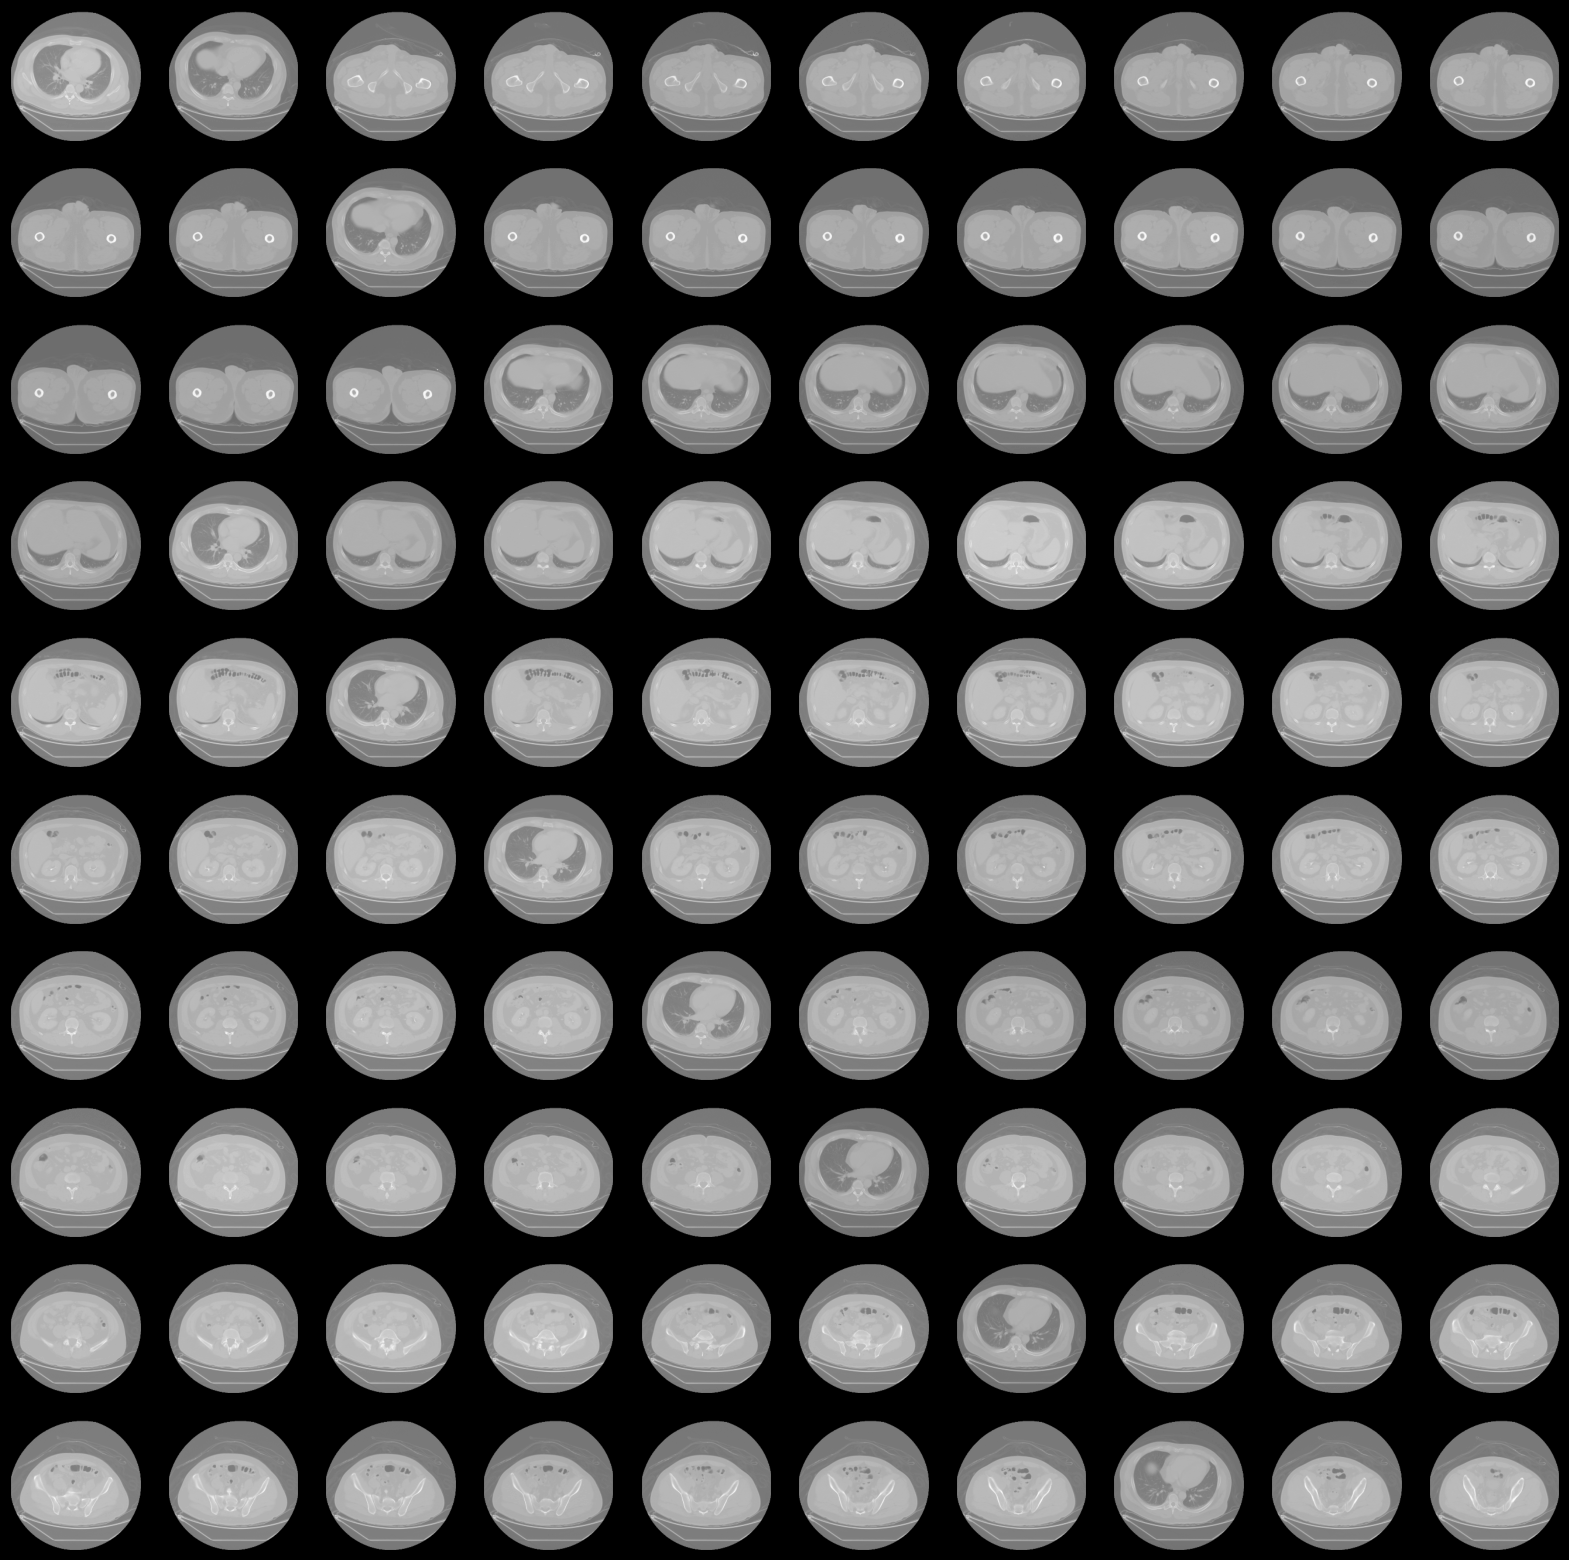

In [8]:
paths = df_bowel.image_path.iloc[0:100]

fig = plt.figure(figsize=(20,20))
fig.set_facecolor('black')
#fig.suptitle('Vanila', fontsize=24, y=0.92)

for i in range(100):
    plt.subplot(10, 10, i+1)
    img = cv2.imread(paths[i], cv2.IMREAD_UNCHANGED)
    #plt.title(path.split('/')[-1])
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.show()

2024-01-15 01:35:21.850247: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-15 01:35:21.850272: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-01-15 01:35:21.850277: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-01-15 01:35:21.850311: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-15 01:35:21.850327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for 

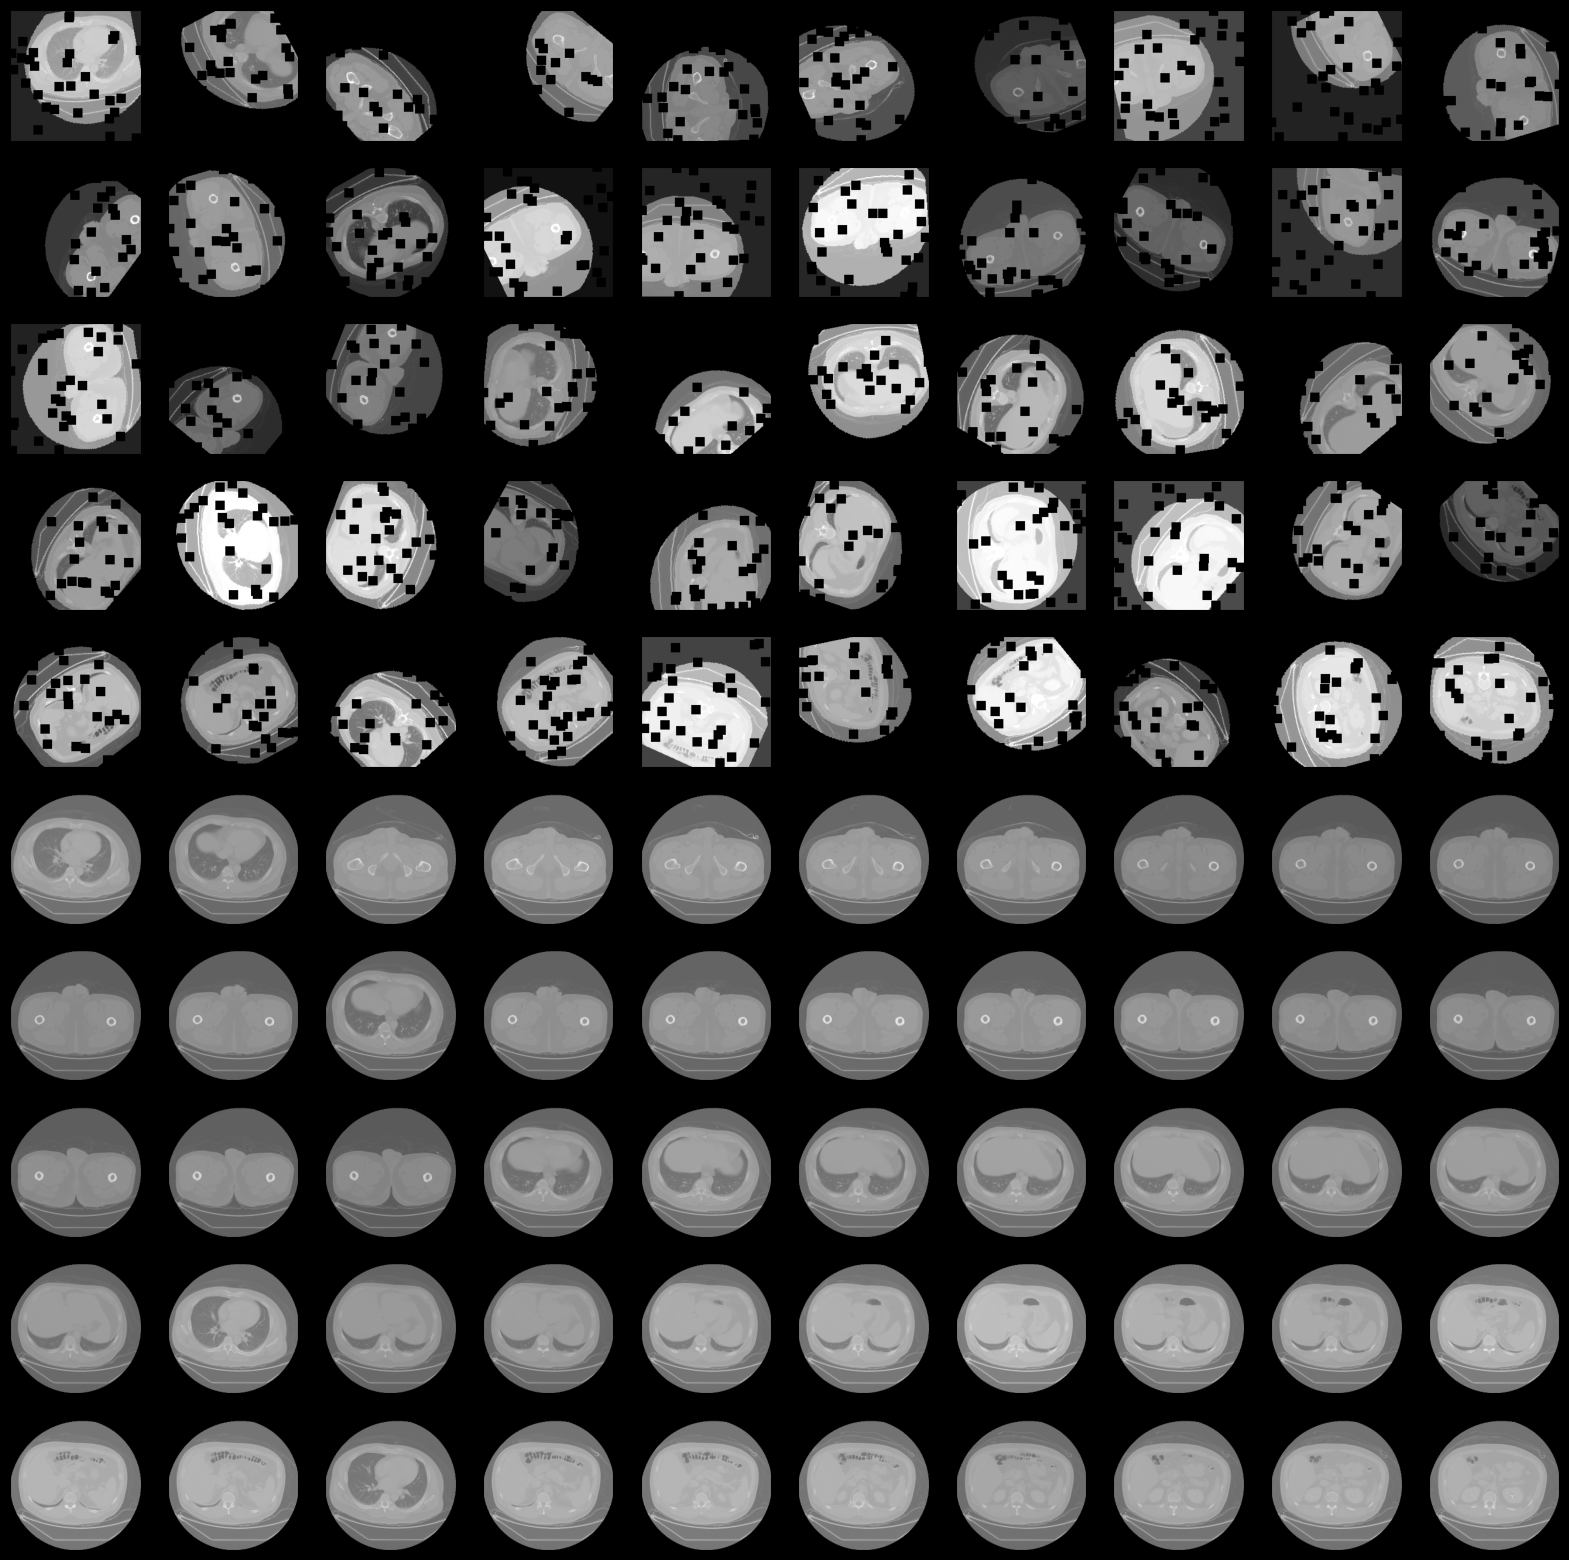

In [9]:
paths = df_bowel.image_path.iloc[0:50]
labels = df_bowel[CFG.target_col].values[0:50]

ds = build_dataset(paths, labels, cache=False, batch_size=32,
                   repeat=False, shuffle=True, augment=True)

ds = ds.unbatch().batch(100)
batch = next(iter(ds))

images, targets = batch

fig = plt.figure(figsize=(20, 20))
fig.set_facecolor('black')
#fig.suptitle('Flavored', fontsize=24, y=0.92)

for i in range(100):
    plt.subplot(10, 10, i+1)
    image = images[i, ]
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.show() 

### Build Model

In [10]:
def build_model(model_name=CFG.model_name, dim=CFG.img_size):

        # backbone
        base = getattr(mobilenet_v2, model_name)(include_top=False, input_shape=(*dim, 3), weights='imagenet', pooling='avg')

        inp = base.inputs

        x = base.output
        #x = tf.keras.layers.GlobalAveragePooling2D()(x)

        # necks
        x_bowel = tf.keras.layers.Dense(32, activation='silu')(x)

        # heads
        out_bowel = tf.keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)

        out = [out_bowel]

        model = tf.keras.Model(inputs=inp, outputs=out)

        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)

        loss = {'bowel':tf.keras.losses.BinaryCrossentropy()}

        metrics = {'bowel':'accuracy'}

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        return model


### Training

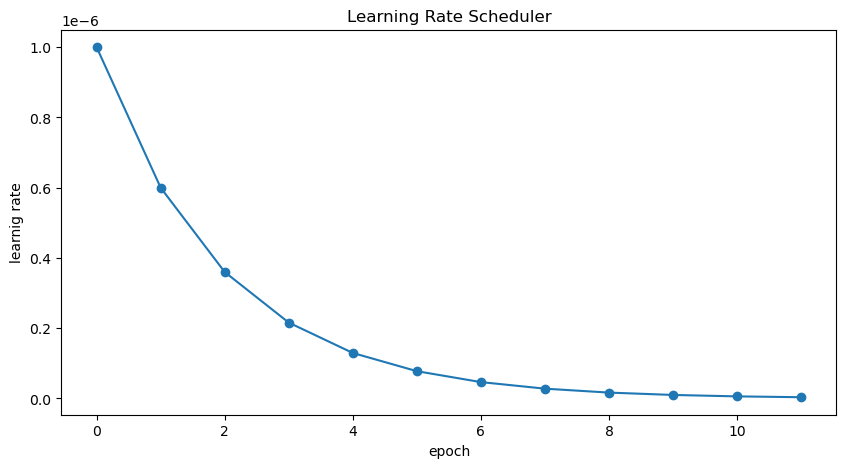

In [11]:
def get_lr_callback(batch_size=8, plot=False):

    initial_lr = 1e-6
   
    def lrfn(epoch):

        lr = initial_lr * 0.60 ** epoch

        return lr
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        #plt.yscale('log')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(CFG.batch_size, plot=True)

In [12]:
os.makedirs('./poc_ckpt/mobilenetv2/', exist_ok=True)

dic_val_losses = {}

for fold in np.arange(CFG.folds):

    train_df = df_bowel.query("fold!=@fold")
    valid_df = df_bowel.query("fold==@fold")

    train_paths  = train_df.image_path.values
    train_labels = train_df[CFG.target_col].values.astype(np.float32)
    valid_paths  = valid_df.image_path.values
    valid_labels = valid_df[CFG.target_col].values.astype(np.float32)
    #test_paths   = test_df.image_path.values

    K.clear_session()

    model = build_model(CFG.model_name, dim=CFG.img_size)

    train_ds = build_dataset(train_paths, train_labels)
    valid_ds = build_dataset(valid_paths, valid_labels)

    ## save best model after each fold
    save = tf.keras.callbacks.ModelCheckpoint('./poc_ckpt/mobilenetv2/fold-%i.h5'%fold, monitor='val_loss', 
                                              verbose=1, save_best_only=True,
                                              save_weights_only=False, mode='min', save_freq='epoch')
    
    logs='./logs/poc/mobilenetv2/fit/' + datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs, update_freq='epoch')
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0, mode='min', baseline=None, restore_best_weights=True)
    
    callbacks_list = []
    callbacks_list.append(save)
    callbacks_list.append(get_lr_callback(CFG.batch_size))
    callbacks_list.append(tensorboard_callback)
    callbacks_list.append(earlystopping_callback)

    history = model.fit(train_ds, validation_data = valid_ds, 
                        epochs=CFG.epochs, steps_per_epoch=None, 
                        callbacks = callbacks_list, max_queue_size=1, verbose=1)
                        
    best_epoch = np.argmin(history.history['val_loss'])
    best_loss = history.history['val_loss'][best_epoch]
    best_acc = history.history['val_accuracy'][best_epoch]

    print(f'FOLD {fold} RESULTS')
    print(f'BEST Loss  : {best_loss:.3f}\nBEST Acc   : {best_acc:.3f}\nBEST Epoch : {best_epoch}')

    dic_val_losses[fold] = best_loss

K.clear_session()
gc.collect()


Epoch 1/12


2024-01-15 01:35:30.367043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2741/2741 [==============================] - ETA: 0s - loss: 0.5855 - accuracy: 0.6864
Epoch 1: val_loss improved from inf to 0.67096, saving model to ./poc_ckpt/mobilenetv2/fold-0.h5
2741/2741 [==============================] - 349s 125ms/step - loss: 0.5855 - accuracy: 0.6864 - val_loss: 0.6710 - val_accuracy: 0.6403 - lr: 1.0000e-06
Epoch 2/12
2741/2741 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.7271
Epoch 2: val_loss did not improve from 0.67096
2741/2741 [==============================] - 339s 123ms/step - loss: 0.5350 - accuracy: 0.7271 - val_loss: 0.8584 - val_accuracy: 0.5104 - lr: 6.0000e-07
FOLD 0 RESULTS
BEST Loss  : 0.671
BEST Acc   : 0.640
BEST Epoch : 0
Epoch 1/12
2507/2507 [==============================] - ETA: 0s - loss: 0.6366 - accuracy: 0.6384
Epoch 1: val_loss improved from inf to 0.80035, saving model to ./poc_ckpt/mobilenetv2/fold-1.h5
2507/2507 [==============================] - 296s 116ms/step - loss: 0.6366 - accuracy: 0.6384 - val

105917

In [13]:
test_df = pd.read_csv('./Dataset/test/test.csv')

In [14]:
CKPT_DIRS = [ (CFG.img_size, './poc_ckpt/mobilenetv2/'),]

MODEL_CONFIGS = []
for img_size, ckpt_dir in  CKPT_DIRS:
    paths = sorted(glob(os.path.join(ckpt_dir, '*h5')))[0:CFG.folds]
    MODEL_CONFIGS.append([img_size, paths])
display(MODEL_CONFIGS)

[[[224, 224],
  ['./poc_ckpt/mobilenetv2/fold-0.h5',
   './poc_ckpt/mobilenetv2/fold-1.h5',
   './poc_ckpt/mobilenetv2/fold-2.h5',
   './poc_ckpt/mobilenetv2/fold-3.h5']]]

In [15]:
def post_proc(pred):
    proc_pred = np.empty(2*1, dtype='float32')

    proc_pred[0] = 1 - pred[0] # bowel-healthy
    proc_pred[1] = pred[0] # bowel-injured

    return proc_pred


patient_ids = test_df['patient_id'].unique()

patient_ids.sort()

patient_preds = np.zeros(shape=(len(patient_ids), 2), dtype='float32')

preds = np.zeros(shape=(1, 1), dtype=np.float32)

for pidx, patient_id in tqdm(enumerate(patient_ids)):

    patient_df = test_df[test_df['patient_id'] == patient_id]

    test_paths   = patient_df.image_path.values

    test_ds = build_dataset(test_paths, augment=False)

    model_preds = np.zeros(shape=(1, 1), dtype=np.float32)

    print(f'Patient ID: {patient_id}')

    for midx, (img_size, fold_paths) in enumerate(MODEL_CONFIGS):

        patient_images = patient_df.image_path.tolist()

        min_batchsize = len(patient_images)
        CFG.batch_size = min(min_batchsize, CFG.batch_size)

        dtest = build_dataset(patient_images, batch_size=CFG.batch_size, cache=False,
                                   decode_fn=build_decoder(with_labels=False, target_size=CFG.img_size))
        
        for fold_path in fold_paths:

            model = tf.keras.models.load_model(fold_path, compile=False)
    
            pred5 = model.predict(dtest, verbose=1)
            pred4 = np.concatenate(pred5, axis=-1).astype('float32')
            pred3 = pred4[:len(patient_images)]
            pred2 = np.mean(pred3.reshape(1, len(patient_images), 1), axis=0)
            pred = np.max(pred2, axis=0) # taking max prediction of all ct scans for a patient
        
            model_preds += pred / (len(fold_paths))
                            
            del model; gc.collect()
        
        del dtest, patient_images; gc.collect()

    patient_preds[pidx, :] += post_proc(pred)

    del model_preds
    K.clear_session()
    gc.collect()


0it [00:00, ?it/s]

Patient ID: 537
63/63 [==============================] - 2s 21ms/step


1it [00:13, 13.75s/it]

Patient ID: 902
132/132 [==============================] - 4s 23ms/step


2it [00:34, 18.00s/it]

Patient ID: 908
179/179 [==============================] - 5s 23ms/step


3it [01:00, 21.68s/it]

Patient ID: 1900
168/168 [==============================] - 5s 25ms/step


4it [01:27, 23.60s/it]

Patient ID: 1938
161/161 [==============================] - 6s 25ms/step


5it [01:53, 24.47s/it]

Patient ID: 3308
189/189 [==============================] - 6s 21ms/step


6it [02:20, 25.32s/it]

Patient ID: 4331
249/249 [==============================] - 8s 26ms/step


7it [02:56, 29.00s/it]

Patient ID: 4720
174/174 [==============================] - 6s 25ms/step


8it [03:25, 28.82s/it]

Patient ID: 5273
64/64 [==============================] - 3s 36ms/step


9it [03:45, 26.05s/it]

Patient ID: 5973
39/39 [==============================] - 3s 44ms/step


10it [04:02, 23.37s/it]

Patient ID: 6780
180/180 [==============================] - 6s 21ms/step


11it [04:29, 24.42s/it]

Patient ID: 7188
175/175 [==============================] - 5s 21ms/step


12it [04:55, 24.90s/it]

Patient ID: 8420
96/96 [==============================] - 3s 23ms/step


13it [05:15, 23.39s/it]

Patient ID: 9093
231/231 [==============================] - 7s 20ms/step


14it [05:46, 25.73s/it]

Patient ID: 10127
376/376 [==============================] - 10s 21ms/step


15it [06:30, 31.36s/it]

Patient ID: 12008
66/66 [==============================] - 5s 41ms/step


16it [06:55, 29.28s/it]

Patient ID: 12898
70/70 [==============================] - 5s 43ms/step


17it [07:20, 28.08s/it]

Patient ID: 13769
75/75 [==============================] - 4s 43ms/step


18it [07:46, 27.31s/it]

Patient ID: 14654
62/62 [==============================] - 5s 45ms/step


19it [08:09, 26.20s/it]

Patient ID: 16195
30/30 [==============================] - 3s 38ms/step


20it [08:27, 23.68s/it]

Patient ID: 16198
39/39 [==============================] - 4s 66ms/step


21it [08:51, 23.75s/it]

Patient ID: 16335
66/66 [==============================] - 5s 45ms/step


22it [09:17, 24.46s/it]

Patient ID: 16682
62/62 [==============================] - 5s 48ms/step


23it [09:44, 25.14s/it]

Patient ID: 17178
76/76 [==============================] - 5s 44ms/step


24it [10:12, 26.01s/it]

Patient ID: 17890
40/40 [==============================] - 5s 69ms/step


25it [10:39, 26.20s/it]

Patient ID: 18905
213/213 [==============================] - 8s 28ms/step


26it [11:18, 30.32s/it]

Patient ID: 19448
80/80 [==============================] - 4s 26ms/step


27it [11:43, 28.54s/it]

Patient ID: 19855
71/71 [==============================] - 5s 49ms/step


28it [12:13, 29.13s/it]

Patient ID: 20454
67/67 [==============================] - 5s 27ms/step


29it [12:38, 27.81s/it]

Patient ID: 20689
278/278 [==============================] - 9s 27ms/step


30it [13:25, 33.49s/it]

Patient ID: 20930
138/138 [==============================] - 8s 33ms/step


31it [14:01, 34.26s/it]

Patient ID: 21759
152/152 [==============================] - 6s 24ms/step


32it [14:32, 33.29s/it]

Patient ID: 22099
292/292 [==============================] - 8s 21ms/step


33it [15:16, 36.58s/it]

Patient ID: 23185
449/449 [==============================] - 13s 24ms/step


34it [16:22, 45.38s/it]

Patient ID: 23332
198/198 [==============================] - 10s 36ms/step


35it [17:08, 45.66s/it]

Patient ID: 24329
157/157 [==============================] - 9s 40ms/step


36it [17:53, 45.24s/it]

Patient ID: 24975
190/190 [==============================] - 11s 37ms/step


37it [18:44, 46.93s/it]

Patient ID: 29565
51/51 [==============================] - 6s 41ms/step


38it [19:15, 42.15s/it]

Patient ID: 30628
174/174 [==============================] - 10s 39ms/step


39it [20:05, 44.53s/it]

Patient ID: 31777
41/41 [==============================] - 7s 100ms/step


40it [20:44, 43.12s/it]

Patient ID: 32197
63/63 [==============================] - 6s 39ms/step


41it [21:16, 39.76s/it]

Patient ID: 33029
243/243 [==============================] - 10s 25ms/step


42it [22:04, 42.12s/it]

Patient ID: 33182
253/253 [==============================] - 9s 25ms/step


43it [22:52, 43.94s/it]

Patient ID: 33610
49/49 [==============================] - 6s 48ms/step


44it [23:24, 40.32s/it]

Patient ID: 34354
111/111 [==============================] - 10s 59ms/step


45it [24:13, 42.85s/it]

Patient ID: 34386
29/29 [==============================] - 9s 173ms/step


46it [24:56, 43.05s/it]

Patient ID: 35138
51/51 [==============================] - 6s 49ms/step


47it [25:29, 40.06s/it]

Patient ID: 35574
200/200 [==============================] - 12s 41ms/step


48it [26:29, 46.05s/it]

Patient ID: 35941
184/184 [==============================] - 9s 28ms/step


49it [27:16, 46.21s/it]

Patient ID: 36017
66/66 [==============================] - 9s 82ms/step


50it [28:04, 46.79s/it]

Patient ID: 36686
82/82 [==============================] - 11s 78ms/step


51it [28:57, 48.73s/it]

Patient ID: 37425
139/139 [==============================] - 12s 58ms/step


52it [29:55, 51.37s/it]

Patient ID: 38067
170/170 [==============================] - 12s 49ms/step


53it [30:55, 53.98s/it]

Patient ID: 38088
112/112 [==============================] - 8s 35ms/step


54it [31:38, 50.64s/it]

Patient ID: 38109
59/59 [==============================] - 10s 103ms/step


55it [32:29, 50.84s/it]

Patient ID: 40740
171/171 [==============================] - 13s 50ms/step


56it [33:31, 54.13s/it]

Patient ID: 41392
163/163 [==============================] - 13s 51ms/step


57it [34:33, 56.59s/it]

Patient ID: 41565
28/28 [==============================] - 7s 84ms/step


58it [35:11, 50.96s/it]

Patient ID: 42358
78/78 [==============================] - 12s 94ms/step


59it [36:09, 53.06s/it]

Patient ID: 42915
65/65 [==============================] - 8s 53ms/step


60it [36:50, 49.38s/it]

Patient ID: 44365
142/142 [==============================] - 15s 58ms/step


61it [37:59, 55.16s/it]

Patient ID: 44861
92/92 [==============================] - 8s 44ms/step


62it [38:44, 52.27s/it]

Patient ID: 45718
46/46 [==============================] - 14s 198ms/step


63it [39:42, 53.83s/it]

Patient ID: 46680
41/41 [==============================] - 10s 155ms/step


64it [40:41, 55.48s/it]

Patient ID: 46909
75/75 [==============================] - 11s 94ms/step


65it [41:41, 56.90s/it]

Patient ID: 47201
262/262 [==============================] - 16s 43ms/step


66it [43:02, 64.06s/it]

Patient ID: 47486
24/24 [==============================] - 7s 134ms/step


67it [43:46, 58.10s/it]

Patient ID: 47975
227/227 [==============================] - 16s 47ms/step


68it [45:06, 64.54s/it]

Patient ID: 48128
28/28 [==============================] - 10s 219ms/step


69it [46:04, 62.75s/it]

Patient ID: 48330
59/59 [==============================] - 11s 60ms/step


70it [46:54, 58.83s/it]

Patient ID: 48514
194/194 [==============================] - 19s 58ms/step


71it [48:16, 65.76s/it]

Patient ID: 48684
29/29 [==============================] - 9s 144ms/step


72it [49:05, 60.66s/it]

Patient ID: 48793
159/159 [==============================] - 11s 37ms/step


73it [50:06, 60.87s/it]

Patient ID: 49044
29/29 [==============================] - 17s 334ms/step


74it [51:13, 62.62s/it]

Patient ID: 49255
46/46 [==============================] - 17s 206ms/step


75it [52:28, 66.38s/it]

Patient ID: 49505
155/155 [==============================] - 18s 74ms/step


76it [53:57, 73.31s/it]

Patient ID: 50219
259/259 [==============================] - 21s 55ms/step


77it [55:34, 80.44s/it]

Patient ID: 50833
154/154 [==============================] - 19s 77ms/step


78it [57:07, 84.10s/it]

Patient ID: 54828
42/42 [==============================] - 18s 264ms/step


79it [58:28, 83.22s/it]

Patient ID: 56050
311/311 [==============================] - 23s 48ms/step


80it [1:00:15, 90.39s/it]

Patient ID: 57055
187/187 [==============================] - 21s 75ms/step


81it [1:01:54, 92.98s/it]

Patient ID: 58547
168/168 [==============================] - 15s 43ms/step


82it [1:03:08, 87.33s/it]

Patient ID: 59270
100/100 [==============================] - 20s 127ms/step


83it [1:04:42, 89.12s/it]

Patient ID: 59737
25/25 [==============================] - 18s 440ms/step


84it [1:06:09, 88.48s/it]

Patient ID: 59982
229/229 [==============================] - 23s 64ms/step


85it [1:07:54, 93.54s/it]

Patient ID: 60009
191/191 [==============================] - 22s 71ms/step


86it [1:09:36, 95.96s/it]

Patient ID: 60515
69/69 [==============================] - 13s 77ms/step


87it [1:10:42, 87.22s/it]

Patient ID: 60836
200/200 [==============================] - 23s 71ms/step


88it [1:12:28, 92.78s/it]

Patient ID: 62095
26/26 [==============================] - 19s 450ms/step


89it [1:13:59, 92.31s/it]

Patient ID: 62118
168/168 [==============================] - 15s 43ms/step


90it [1:15:19, 88.60s/it]

Patient ID: 62705
163/163 [==============================] - 16s 45ms/step


91it [1:16:38, 85.61s/it]

Patient ID: 62845
116/116 [==============================] - 22s 117ms/step


92it [1:18:18, 89.88s/it]

Patient ID: 63325
41/41 [==============================] - 13s 122ms/step


93it [1:19:27, 83.67s/it]

Patient ID: 63338
178/178 [==============================] - 16s 44ms/step


94it [1:20:47, 82.64s/it]

Patient ID: 64428
74/74 [==============================] - 20s 165ms/step


95it [1:22:23, 86.68s/it]

Patient ID: 64573
174/174 [==============================] - 16s 44ms/step


96it [1:23:44, 84.81s/it]

Patient ID: 65083
59/59 [==============================] - 21s 217ms/step


97it [1:25:22, 88.96s/it]

Patient ID: 65360
35/35 [==============================] - 20s 318ms/step


98it [1:26:59, 91.26s/it]

Patient ID: 65415
30/30 [==============================] - 20s 389ms/step


99it [1:28:36, 92.82s/it]

Patient ID: 65456
62/62 [==============================] - 21s 196ms/step


100it [1:30:14, 54.15s/it]


In [16]:
answer_df = pd.read_csv('./Dataset/test/answer.csv')

In [21]:
pred_bowel = pd.DataFrame({'patient_id':patient_ids,})

for i, row in enumerate(patient_preds):
    pred_bowel.loc[i, 'bowel_healthy'] = row[1]
    pred_bowel.loc[i, 'bowel_injury'] = row[0]

pred_df = pred_bowel.sort_values('patient_id')

Bowel thresholds:
[       inf 0.26115048 0.25948036 0.24751163 0.22927904 0.22714865
 0.22622138 0.21713954 0.21538669 0.21105969 0.20838082 0.2043857
 0.20424849 0.20409846 0.19776064 0.19715583 0.19661993 0.19304633
 0.19148731 0.19094932 0.19075429 0.18967235 0.18561566 0.18468177
 0.18446743 0.18312341 0.18113637 0.17735362 0.17606837 0.17603678
 0.17346692 0.17320395 0.16480672 0.16427153 0.16281807 0.15780514
 0.15777069 0.15716302 0.15683651 0.15646559 0.15579301 0.15561181
 0.15508014 0.15166008 0.1506083  0.14969134 0.1495502  0.14868307
 0.14793915 0.14614111 0.14380395 0.14274001 0.13930851 0.13874555
 0.13860124 0.13836044 0.1380558  0.13737959 0.13679641 0.13638347
 0.13606697 0.13333476 0.13269085 0.13181758 0.12990016 0.12941456
 0.12937129 0.12717676 0.12562835 0.12495565 0.12430912 0.12421137
 0.12282968 0.12036401 0.11883658 0.1178934  0.11727601 0.11713332
 0.1154238  0.11428487 0.11352623 0.11247009 0.11143935 0.10855275
 0.103661   0.10218459 0.10196882 0.10045463 

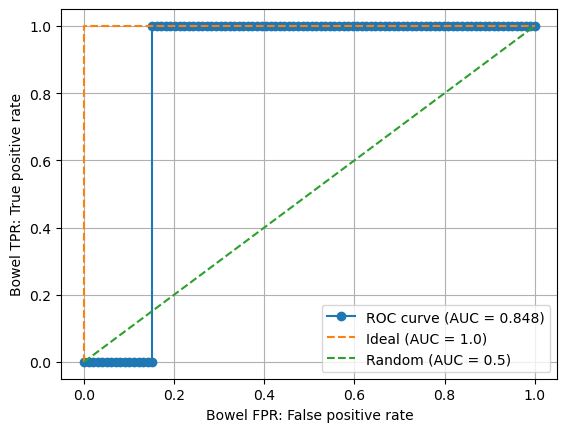

In [22]:
bowel_pred = pred_bowel['bowel_injury'].to_list()
bowel_ans = answer_df['bowel_injury'].to_list()
bowel_roc = roc(bowel_ans, bowel_pred, drop_intermediate=False)
bowel_fpr, bowel_tpr, bowel_thresholds = bowel_roc

plt.plot(bowel_fpr, bowel_tpr, marker='o', label='ROC curve (AUC = %0.3f)' % auc(bowel_ans, bowel_pred))
plt.plot([0,0,1], [0,1,1], linestyle='--', label='Ideal (AUC = 1.0)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random (AUC = 0.5)')
plt.xlabel('Bowel FPR: False positive rate')
plt.ylabel('Bowel TPR: True positive rate')
plt.legend()
plt.grid()
plt.show

print(f'Bowel thresholds:\n{bowel_thresholds}')

In [19]:
def to_one_hot(feature, thresholds):

    organ = feature.split('_')[0]
    pred_df = f'pred_{organ}'
    name1 = f'prediction_{feature}'
    globals()[name1] = globals()[pred_df][feature].to_list()
    name3 = f'one_hot_{feature}'
    globals()[name3] = {}

    for t in thresholds:
        name2 = f'one_hot_{feature}_{str(t)}'
        globals()[name2] = globals()[name1].copy()

        for i, v in enumerate(globals()[name2]):
            if t == float('inf'):
                globals()[name2][i] = 0
            elif v >= t:
                globals()[name2][i] = 1
            elif v < t:
                globals()[name2][i] = 0
        
        globals()[name3][t] = globals()[name2]

    return globals()[name3]

In [20]:
one_hot_bowel_injury = to_one_hot('bowel_injury', bowel_thresholds)


l_bowel = []

for key, value in one_hot_bowel_injury.items():

    if recall(bowel_ans, value) == 1.0:
        l_bowel.append(key)

best_threshold_bowel = max(l_bowel)


print('TN FP\nFN TP')

print('\n')

print('Bowel confusion matrix:')
print(cm(bowel_ans, one_hot_bowel_injury[best_threshold_bowel]))
print(f'Bowel accuracy: {accuracy(bowel_ans, one_hot_bowel_injury[best_threshold_bowel])}')

TN FP
FN TP


Bowel confusion matrix:
[[15 84]
 [ 0  1]]
Bowel accuracy: 0.16


ROC: 0.848, time: 5415sec